<a href="https://colab.research.google.com/github/marpulli246/VaasaUniversity-AML/blob/main/Exercises/Markku_PulliExercise5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applied Machine Learning (2021), exercises


## General instructions for all exercises

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Follow the instructions and fill in your solution under the line marked by tag

> YOUR CODE HERE

Do not change other areas of the document, since it may disturb the autograding of your results!
  
Having written the answer, execute the code cell by and pressing `Shift-Enter` key combination. The code is run, and it may print some information under the code cell. The focus automatically moves to the next cell and you may "execute" that cell by pressing `Shift-Enter` again, until you have reached the code cell which tests your solution. Execute that and follow the feedback. Usually it either says that the solution seems acceptable, or reports some errors. You can go back to your solution, modify it and repeat everything until you are satisfied. Then proceed to the next task.
   
Repeat the process for all tasks.

The notebook may also contain manually graded answers. Write your manualle graded answer under the line marked by tag:

> YOUR ANSWER HERE

Manually graded tasks may be text, pseudocode, or mathematical formulas. You can write formulas with $\LaTeX$-syntax by enclosing the formula with dollar signs (`$`), for example `$f(x)=2 \pi / \alpha$`, will produce $f(x)=2 \pi / \alpha$

When you have passed the tests in the notebook, and you are ready to submit your solutions, download the whole notebook, using menu `File -> Download as -> Notebook (.ipynb)`. Save the file in your hard disk, and submit it in [Moodle](https://moodle.uwasa.fi) under the corresponding excercise.

Your solution should be an executable Python code. Use the code already existing as an example of Python programing and read more from the numerous Python programming material from the Internet if necessary. 


In [ ]:
NAME = "Markku Pulli"
Student_number = "121763"

---

# Classification exercises


## Satellite image classification

Following satellite image is obtained from the Söderfjärden meteorite crater near Vaasa at 10:00 in 28.9.2019. The image is acquired from European Sentinell 2 satellite by means of multispectral imaging device (MSI). The multispectral camera has acquired the image using 13 different wavelength bands instead of three (RGB) in the normal camera. The image was searched and dowloaded using [Copernicus Open Access Hub](https://scihub.copernicus.eu/dhus/), and preprosessed by using ESA's [SNAP](http://step.esa.int/main/download/) tool.


The bands used are 

| Band number | Band name | Wavelength | Region | Remarks |
| ----------- | --------- | -----------| ------ | ------- |
|  1 | B1  |   443 nm | Violet     | Chlorophyll-A |
|  2 | B2  |   490 nm | Cyan       | |
|  3 | B3  |   560 nm | Green      | |
|  4 | B4  |   665 nm | Red        | Chlorophyll_A |
|  5 | B5  |   705 nm | Red        | |
|  6 | B6  |   740 nm | Red        | |
|  7 | B7  |   783 nm | Deep red   | |
|  8 | B8  |   842 nm | NIR        | |
|  9 | B8A |   865 nm | NIR        | |
| 10 | B9  |   945 nm | NIR        | |
| 11 | B10 |  1375 nm | NIR        | |
| 12 | B11 |  1610 nm | NIR        | |
| 13 | B12 |  2190 nm | NIR        | |

The channels listed above can be used for creating a natural looking RGB-image, as shown below.

![machine_learning.svg](https://github.com/pevalisuo/AML/blob/master/Exercises/Exercise5/Soderfjarden_image.png?raw=1)

Even though, only three channels are used for RGB image, all 13 can be usefull features for land type and crops classification. 

## Training data 

In the image above, an expert has manually segmented some areas of the image and labelled them according to land use. The labelled areas are:

| Segment no. | Segment name | Segment color | 
| ----------- | --------- | -----------| 
|  1 | Water      | Violet |
|  2 | Forest     | Green |
|  3 | HayField   | Red |
|  4 | StrawField | Light Green |
|  5 | DarkSoil   | Blue |


## Task 1


### Read the data
Open the training data, which contains the pixel values of the segmented regions shown in the image above. Each pixel contains 13 floating point values between 0 and 1, one for each channel.

The training data is stored in a HDF5 file `Soderfjarden_training_data.h5`, in the subdirectory called as `data`. The file includes the following data sets:

 - `spectra`: a matrix, which dimensions are (23754, 15). Notice that two first values are the x and y coordinates of the pixel. Do not use them for classification, but use only following 13 channels. Construct a design matrix X (23754,13) by slicing this data.
 - `labels`: The expert segmented labels (23754, 1), the true values, the ground truth. This is the y-vector which you try to predict
 - `columns`: The name of the columns (15,1), if you need them. Contains the band names, shown in he table above, plus the name of the x and y coordinate columns.
 - `wavelengths`: The wavelengts of each band (13,1), the same shown in the table above.
 - The HDF5 includes also a data attribute called `timestamp`, which contains the time when the image was acquired.

The opening of the HDF5-file, and accessing the dataset can be achieved like this:

`fid = h5py.File(<filename>)
 X=fid['spectra'][:,2:]
 y_b=fid['labels'][:]
 ...
 `
 
 Use also the following line of code to decode the bytestrings obtained from HDF5 to utf8 strings (This is irritating, but necessary ). Repeat the same for decoding the column names to utf8.
 
 `y=np.array([label.decode('utf8') for label in y_b])`


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import h5py
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

(array([b'DarkSoil', b'Forest', b'HayField', b'StrawField', b'Water'],
      dtype='|S10'), array([1447, 8491, 1560, 3850, 8406]))


[Text(0.5, 1.0, 'Wavelength Distribution')]

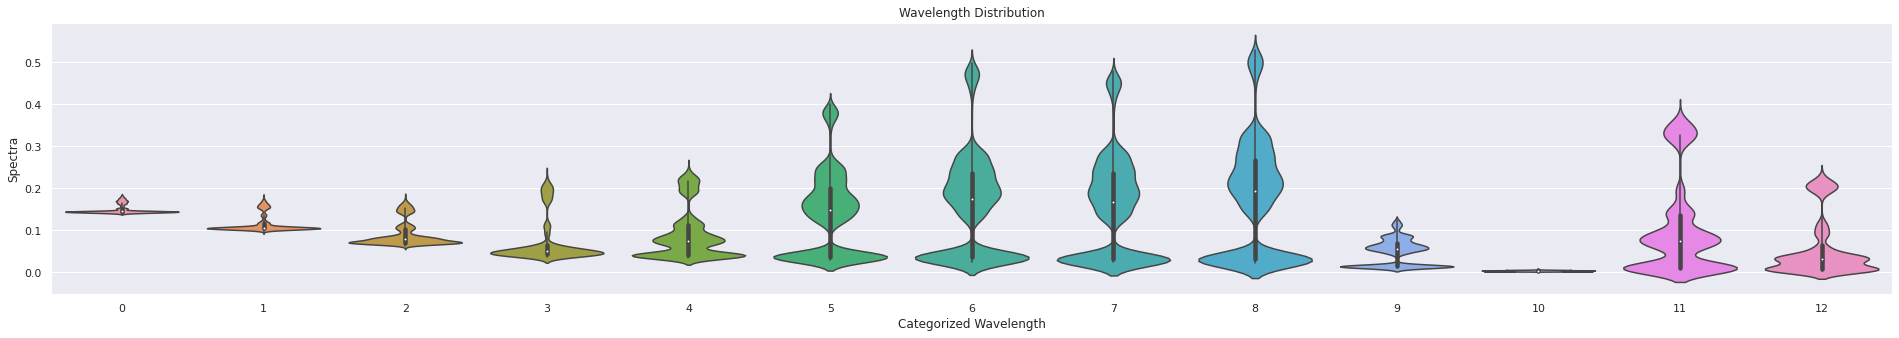

In [2]:
fid = h5py.File('/content/Soderfjarden_training_data.h5') 
list(fid.keys())
X=fid['spectra'][:,2:] 
y_b=fid['labels'][:]
colnames_b=fid['columns'][:]
y=np.array([label.decode('utf8') for label in y_b])
colnames=np.array([label.decode('utf8') for label in colnames_b])
print(np.unique(y_b,return_counts=True))

#Let see distribution of each wavelength.
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(33,5)})
plt.xlabel('Categorized Wavelength')
plt.ylabel('Spectra')
sns.violinplot(data=X[:,0:], scale='width').set(title='Wavelength Distribution')
#Darksoil has least amount of samples. Water and forest about 6 times more. Not perfectly balanced data.

In [3]:
assert(X.shape==(23754,13))
assert(y.shape==(23754,))
assert(colnames.shape==(16,))
assert(y.dtype=='<U10')

## Task 2

Analyze the complexity of the data  by plotting it with two first principal components

 - Transform the the data in PCA domain as `pc`
 - Transform the y-vector to integer vector `yi`, using for example LabelEncoder
 - Plot a scatter plot of two first principal components, where the color is `yi`, the integer representation of `y` (=classes)

0.9965540714224767
[0 0 0 ... 3 3 3]


[Text(0.5, 1.0, 'Manually Segmented Areas')]

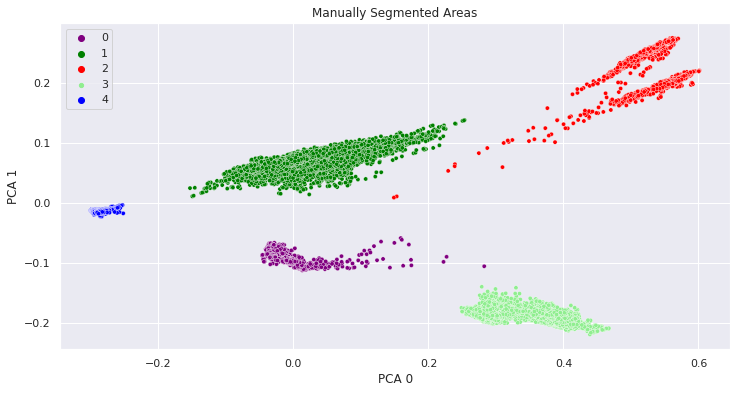

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

# YOUR CODE HERE
pca=PCA(n_components=2)
pc=pca.fit_transform(X)
print(pca.explained_variance_ratio_.sum())
le = LabelEncoder()
#yi=le.fit(y)
yi=le.fit_transform(y)
print(yi)
#plt.scatter(pc[:,0],pc[:,1],c=yi)
#plt.show()
sns.set(rc={'figure.figsize':(12,6)})
plt.xlabel('PCA 0')
plt.ylabel('PCA 1')
color_dict = dict({0:'purple',
                  1:'green',
                  2: 'red',
                  3: 'lightgreen',
                  4: 'blue'})
sns.scatterplot(data=pc, x=pc[:,0], y=pc[:,1], hue=yi, size=3, palette=color_dict,legend='full').set(title='Manually Segmented Areas')

In [5]:
assert(pc.shape==(23754, 2)), "Something is wrong with PCA"
assert((max(yi)-min(yi))==4), "Something is wrong with integer labels"


## Task 3

- Create a processing pipeline using standard scaler and some classification method, name the pipeline as `predictor`
- Train the pipeline and check if it passes the tests for precision in training set
- Separate your data X and y to training set (X_train, y_train) which contains 75% of the data and to the test set X_test, y_test which contains 25% of the data. Use function `train_test_split` from library `sklearn.model_selection`.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn import metrics 
#from sklearn ...

#X_train, X_test, y_train, y_test = ...
#predictor= ...

X_train, X_test, y_train, y_test = train_test_split(pc, yi, test_size=0.25, random_state=42)

predictor = Pipeline([('scaler', StandardScaler()), ('sgdc', SGDClassifier())])

predictor.fit(X_train, y_train)
print('Training score: %0.3f'%predictor.score(X_train, y_train))

#predictor.fit(X_train, y_train)

#print(predictor.score(X_train, y_train))

yh_test=predictor.predict(X_test)
test_score=metrics.accuracy_score(y_true=y_test, y_pred=yh_test) 

print('Test score: %0.3f'%test_score)
np.unique(y_test,return_counts=True)

Training score: 0.982
Test score: 0.981


(array([0, 1, 2, 3, 4]), array([ 351, 2123,  371,  943, 2151]))

In [7]:
# Testing the precision in the training set
yh=predictor.predict(X_train)
train_score=metrics.accuracy_score(y_true=y_train, y_pred=yh)
if len(predictor.steps)<2:
    print("The predictor is not a pipeline. Did you forget scaling?")
assert(len(predictor.steps)>=2)
assert(test_score > 0.95)


In [8]:
print(train_score)

0.9817008139208532


## Task 4: Evaluation of the predictor

Having trained the predictor, evaluate now it's performance using cross validation and test set. You may use `cross_val_score` function from the `sklearn.model_selection` library and `accuracy_score` from the `sklearn.metrics` library.

Print also the confusion matrix to see which areas are miss-classified. Use `confusion_matrix` function from the `sklearn.metrics` library


In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix 
#from sklearn ...
#
#cv_score= ...
#train_score= ...
#test_score= ...

cv_score = cross_val_score(predictor, X_test, y_test, cv=3).mean()
train_score = metrics.accuracy_score(y_train, yh)
test_score = metrics.accuracy_score(y_test, yh_test)
print('Confusion matrix:\n',confusion_matrix(y_test, yh_test))
print('Cross validation: {:.3f}, training score {:.3f}, test score {:.3f}'.format(cv_score, train_score, test_score))

Confusion matrix:
 [[ 245  103    0    0    3]
 [   0 2123    0    0    0]
 [   0    5  366    0    0]
 [   0    0    0  943    0]
 [   0    0    0    0 2151]]
Cross validation: 0.995, training score 0.982, test score 0.981


In [10]:
assert(cv_score > 0.95)
assert(train_score > 0.95)
assert(test_score > 0.95)

## Task 5: Interpretation of the results

1. What is your opinion of the precision you achieved?
1. Can you see signs of overfitting? Why/Why not?
1. Which samples were misclassified? To which class they were assigned?


YOUR ANSWER HERE

In [ ]:
#1. Precision is very high, close to 99% on both training and test data.
#2. No overfit as test data has same level accuracy as training data.
#3. Samples '0' darksoil show most missclassification. It is missclassified as '1' forest, 103 samples. Please note, sample count varies each time model is fitted.